# Capstone project - Brain tumour classification


## Image processing - features extraction

References for the VASARI dataset:
 - Scarpace, Lisa, Flanders, Adam E., Jain, Rajan, Mikkelsen, Tom, & Andrews, David W. (2015). Data From REMBRANDT. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2015.588OZUZB  
 - Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057.

1. [In 2D with one sequence (T1)](#Part1)   
    a. [First option: dicom library & skimage](#Part1a)  
      i. [Tumour isolation with edge detection](#Part1ai)  
      ii. [Tumour isolation with region-based segmentation](#Part1aii)  
    b. [Second option: SimpleITK library](#Part1b)  
      i. [Tumour isloation on T1 image (using confidence connected filter)](#Part1bi)  
      ii. [Tumour isloation on T2 image (using confidence connected filter)](#Part1bii)    
          
2. [In 2D with 4 different sequences (T1, T2, FLAIR and T1 GD)](#Part2)   
   a. [Reshape images](#Part2a)  
   b. [Remove noise](#Part2b)  
   c. [Multimodal segmentation - merge T2 and FLAIR images to get a more accurate tumour delimitation](#Part2c)     
       
3. [In 3D](#Part3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline
pd.set_option("display.max_columns",101)

<a id='Part1'></a>

## 1. In 2D with one sequence (T1)

<a id='Part1a'></a>

### a. First option: dicom library & skimage

In [205]:
import dicom
from skimage import io
import os
import numpy
from matplotlib import cm

In [206]:
# Extracting scans fron the first patient

PathDicom = "../REMBRANDT/900-00-1961/AX_T1"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))

In [207]:
# Get ref file
RefDs = dicom.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]), float(RefDs.SliceThickness))

In [250]:
# DICOM images characteristics
dicom.read_file(lstFilesDCM[0])

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.50.101059839858483772076354011531404942974
(0008, 0020) Study Date                          DA: '20050619'
(0008, 0023) Content Date                        DA: '20050619'
(0008, 0030) Study Time                          TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: '1293190500624970'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 1032)  Procedure Code Sequence   1 item(s) ---- 

   ---------
(0010, 0010) Patient's Name                      PN: '253609'
(0010, 0020) Patient ID                        

In [209]:
# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dicom.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array 

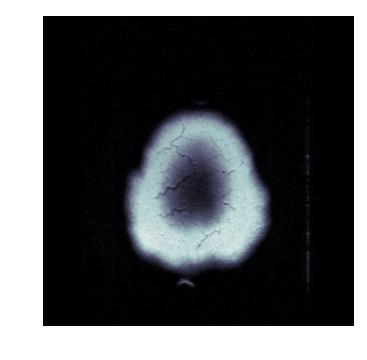

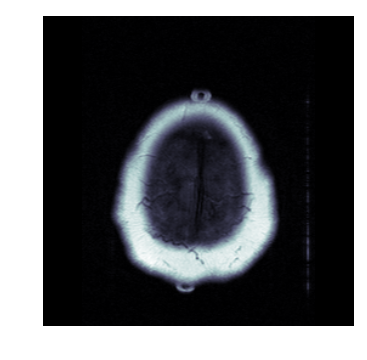

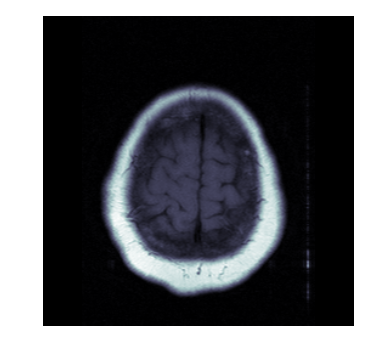

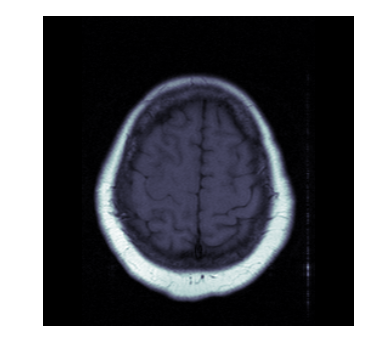

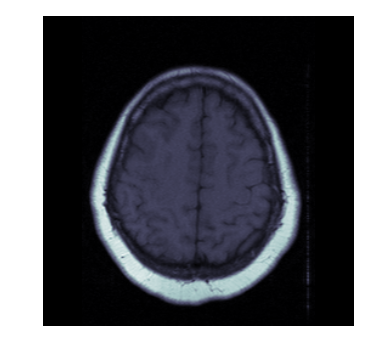

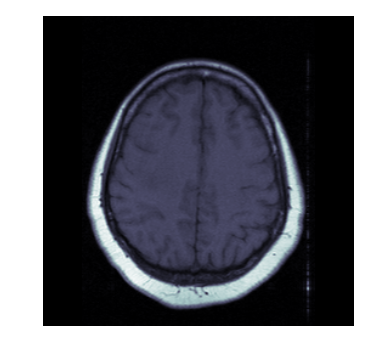

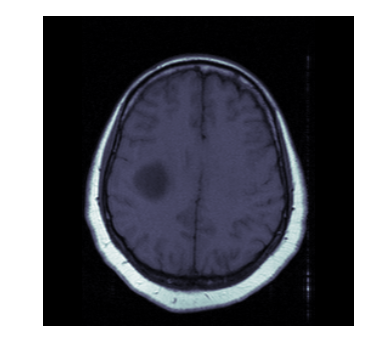

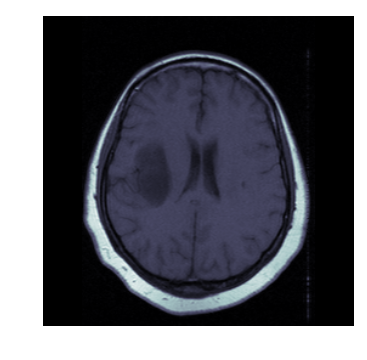

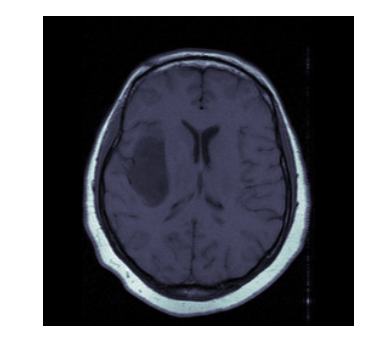

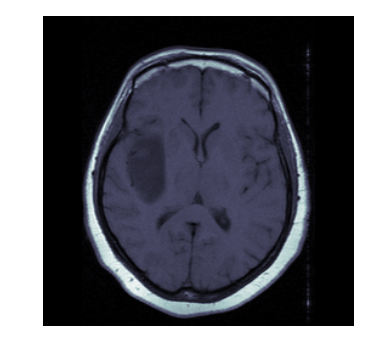

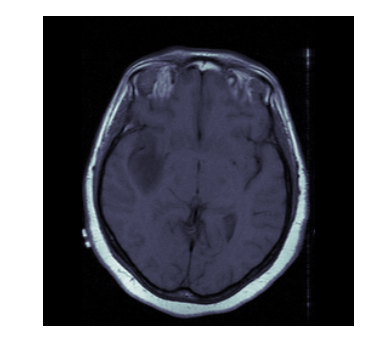

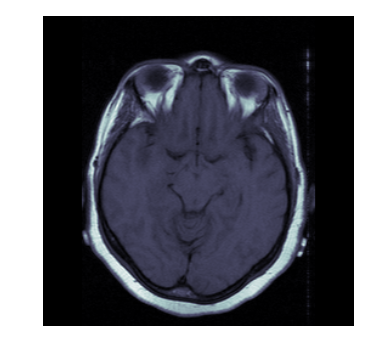

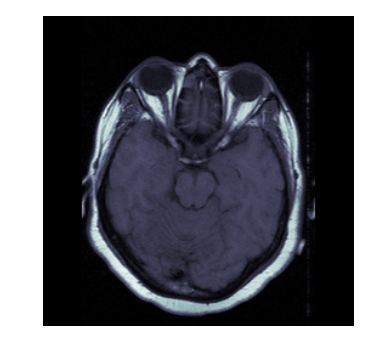

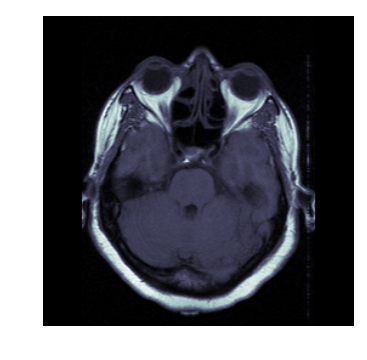

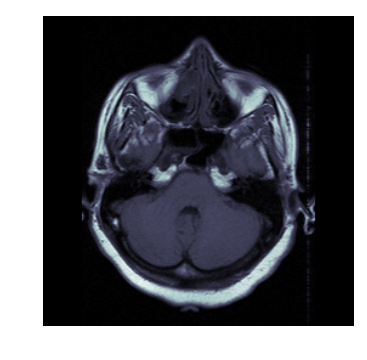

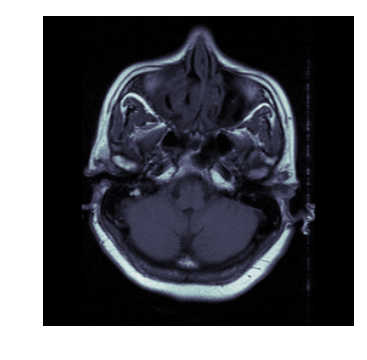

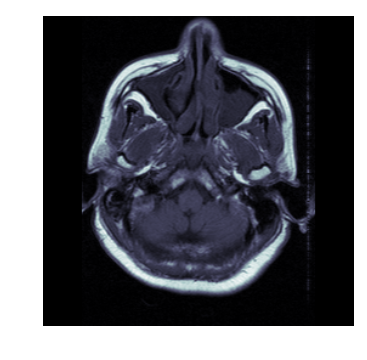

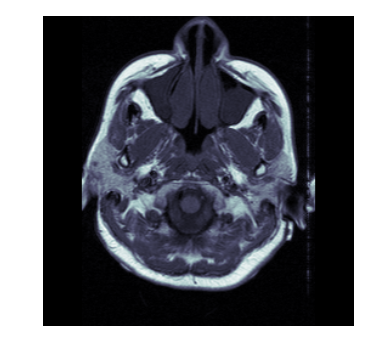

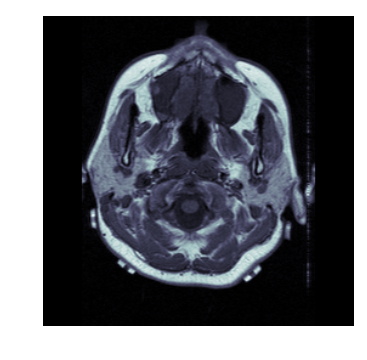

In [210]:
# Display all images in the first sequence of the first patient
import pylab

for i in range(19):
    fig, ax = plt.subplots(dpi=300)
    pylab.imshow(ArrayDicom[:, :, i], cmap=pylab.cm.bone)
    plt.axis('off')
    pylab.show()

<a id='Part1ai'></a>

#### (i) Tumour isolation with edge detection

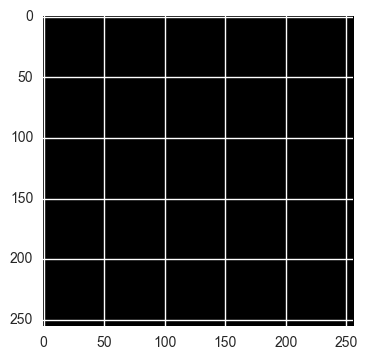

In [220]:
# Edge detection on the image itself didn't give any results

from skimage import feature

edges = feature.canny(ArrayDicom[:, :, 8], sigma=0.5)
pylab.imshow(edges, cmap=pylab.cm.bone)

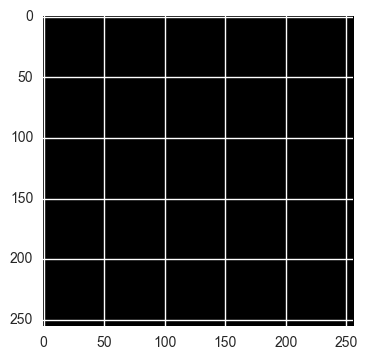

In [221]:
# Edge detection on a Gamma filtered image didn't give any results either

from skimage import exposure
gamma_corrected = exposure.adjust_gamma(ArrayDicom[:, :, 8], 1.5)

edges1 = feature.canny(gamma_corrected, sigma=0.5)
pylab.imshow(edges1, cmap=pylab.cm.bone)

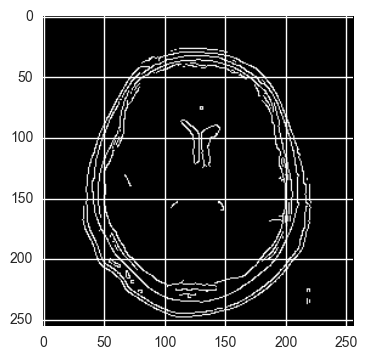

In [222]:
# Edge detection on a logarithmic filtered image wasn't able to detect the tumour
logarithmic_corrected = exposure.adjust_log(ArrayDicom[:, :, 8], 10)

edges2 = feature.canny(logarithmic_corrected, sigma=0.5)

pylab.imshow(edges2, cmap=pylab.cm.bone)

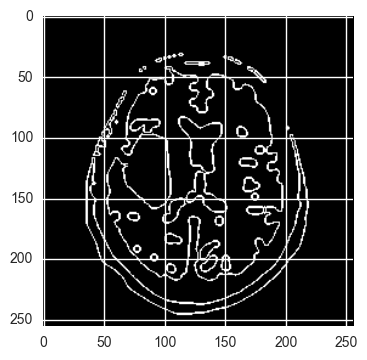

In [223]:
# Edge detection on a logarithmic filtered image with thresholding detected too much
edges3 = feature.canny(logarithmic_corrected>5500, sigma=0.5)

pylab.imshow(edges3, cmap=pylab.cm.bone)

<a id='Part1aii'></a>

#### (ii) Tumour isolation with region-based segmentation

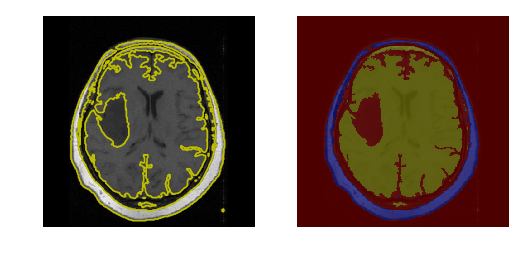

In [243]:
# Find an elevation map using the Sobel gradient of the image

from skimage.filters import sobel
elevation_map = sobel(ArrayDicom[:, :, 8])

# Find markers of the background and the brain based on the extreme parts of the histogram of grey values

markers = np.zeros_like(logarithmic_corrected)
markers[logarithmic_corrected<6000] = 1
markers[logarithmic_corrected>6500] = 2

# Use the watershed transform to fill regions of the elevation map starting from the markers determined above
from skimage import morphology
segmentation = morphology.watershed(elevation_map, markers)

from skimage.color import label2rgb
from scipy import ndimage as ndi

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_regions, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_regions, image=logarithmic_corrected)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(logarithmic_corrected, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box-forced')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box-forced')

These libraries seemed more difficult to use than the next librairy which has been designed specifically for medical images visualisation and analysis. I therefore stopped using DICOM and Skimage to extract tumour features and switched to SimpleITK.

<a id='Part1b'></a>

### b. Second option: SimpleITK library

In [2]:
import SimpleITK

<a id='Part1bi'></a>

#### (i) Tumour isloation on T1 image (using confidence connected filter)

In [121]:
# Load in DICOM images for 1 sequence of 1 patient

PathDicom = "../REMBRANDT/900-00-1961/AX_T1/"

reader = SimpleITK.ImageSeriesReader()
filenamesDICOM = reader.GetGDCMSeriesFileNames(PathDicom)
reader.SetFileNames(filenamesDICOM)
imgOriginal = reader.Execute()

In [122]:
# int labels to assign to the segmented tumour
labelWhiteMatter = 1
labelTumour = 2

In [123]:
# Define a function to display one ITK image

def sitk_show(img, title=None, margin=0.0, dpi=40, axis='off'):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    ax.axis(axis)
    
    if title:
        plt.title(title)
    
    plt.show()

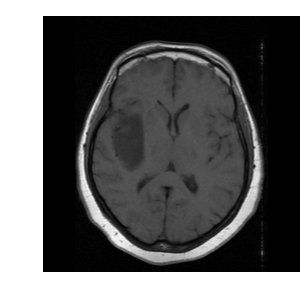

In [124]:
# View one image slice

imgSlice = imgOriginal[:,:,10]

sitk_show(imgSlice, dpi=100)

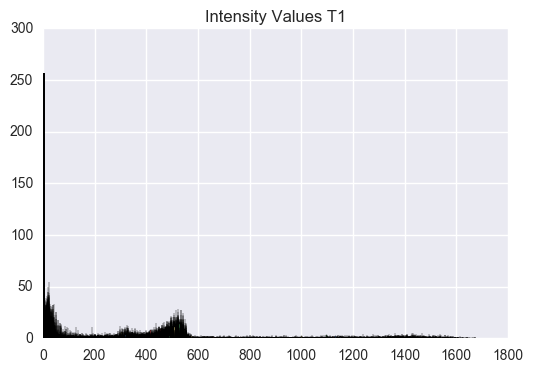

In [7]:
# Get intensity values for this image
intensity_values_T1 = SimpleITK.GetArrayFromImage(imgSlice)

plt.hist(intensity_values_T1, bins=256)
plt.title("Intensity Values T1")
plt.show()

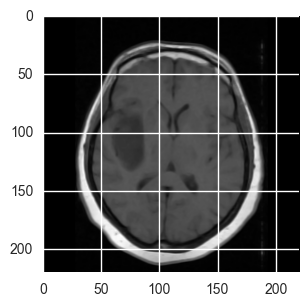

In [125]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth = SimpleITK.CurvatureFlow(image1=imgSlice,
                                    timeStep=0.125,
                                    numberOfIterations=5)

# blurFilter = SimpleITK.CurvatureFlowImageFilter()
# blurFilter.SetNumberOfIterations(5)
# blurFilter.SetTimeStep(0.125)
# imgSmooth = blurFilter.Execute(imgSlice)

sitk_show(imgSmooth, axis='on', dpi=100)

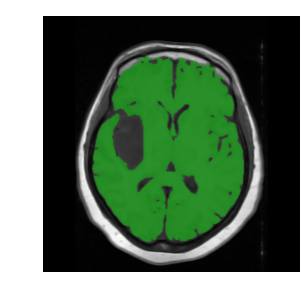

In [126]:
# Segmentation with the ConfidenceConnected filter
# What this filter does is simply “label pixels that are connected to a seed and lie within a range of values”. 
# Essentially, this filter operates on the input image starting from a series of given ‘seed points’. 
# It then starts ‘growing’ a region around those points and keeps adding the neighboring points as long as 
# their values fall within given thresholds.

# Initial segmentation of white matter

lstSeeds = [(150,110)]

imgWhiteMatter = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                               seedList=lstSeeds,
                                               numberOfIterations=5,
                                               multiplier=3,
                                               replaceValue=labelWhiteMatter)

imgSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth), imgWhiteMatter.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatter), dpi=100)

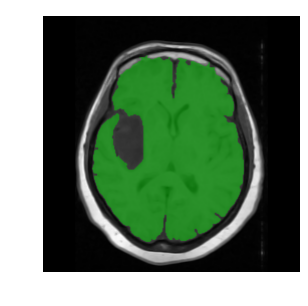

In [127]:
# Fill holes in the white matter label through BinaryClosingByReconstruction

imgWhiteMatterNoHoles = SimpleITK.BinaryClosingByReconstruction(imgWhiteMatter, 10)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgWhiteMatterNoHoles), dpi=100)

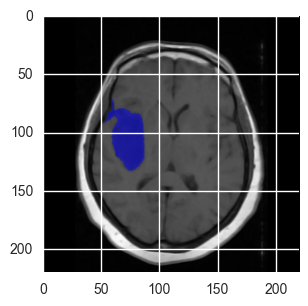

In [128]:
# Segmentation of tumour

lstSeeds = [(80, 120), (70, 130)]

imgTumour = SimpleITK.ConfidenceConnected(image1=imgSmooth, 
                                              seedList=lstSeeds,
                                              numberOfIterations=3,
                                              multiplier=1.75,
                                              replaceValue=labelTumour)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgTumour), axis='on', dpi=100)

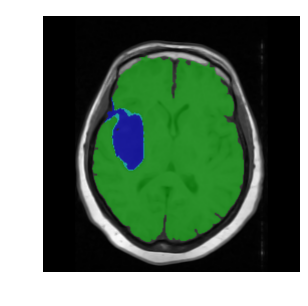

In [129]:
# Bitwire OR combination of the white matter and gray matter labels

imgLabels = imgWhiteMatterNoHoles | imgTumour


sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels), dpi=100)

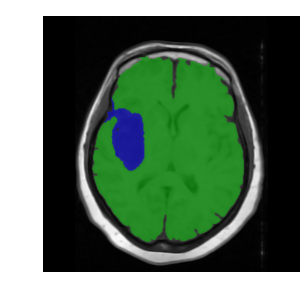

In [130]:
# Assignment of common areas to the tumour

imgMask = (imgWhiteMatterNoHoles / labelWhiteMatter) * (imgTumour / labelTumour)
imgWhiteMatterNoHoles -= imgMask*labelWhiteMatter

imgLabels = imgWhiteMatterNoHoles + imgTumour

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, imgLabels), dpi=100)

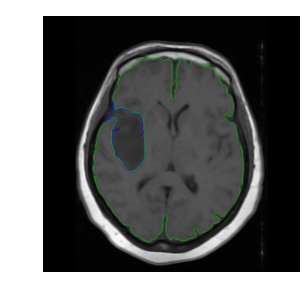

In [131]:
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt, SimpleITK.LabelContour(imgLabels)), axis='off', dpi=100)

In [132]:
# Estimate the tumour radius from the segmented image using the LabelShapeStatisticsImageFilter.
label_shape_analysis = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis.SetBackgroundValue(1)
label_shape_analysis.Execute(imgTumour)
print("The tumour's radius is: {0:.2f}mm".format(label_shape_analysis.GetEquivalentSphericalRadius(labelTumour)))

The tumour's radius is: 19.64mm


In [133]:
# Tumour center location out of 256x256 pixels 
# Assign to 3 if left (ie [0] > 128), 1 if right - HOW TO CHECK IF BILATERAL??
# CAREFUL : this is the side of the brain so will appear opposite on image!

imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))

(84L, 121L)

In [134]:
# = f29 & f30
# Assign labels from 0 to 18 to closest size and insert in df

label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour)

(28.13750164523707, 54.84014536501314)

In [135]:
# Will be needed to compute proportions
label_shape_analysis.GetNumberOfPixels(2)

1641L

<a id='Part1bii'></a>

#### (ii) Tumour isloation on T2 image (using thresholding or confidence connected filter)

In [3]:
# Read-in T2 sequence
PathDicom = "../REMBRANDT/900-00-1961/AX_T2/"

reader_T2 = SimpleITK.ImageSeriesReader()
filenamesDICOM_T2 = reader_T2.GetGDCMSeriesFileNames(PathDicom)
reader_T2.SetFileNames(filenamesDICOM_T2)
imgOriginal_T2 = reader_T2.Execute()

Original image size: (512, 512)
Reshaped image size: (256, 256)


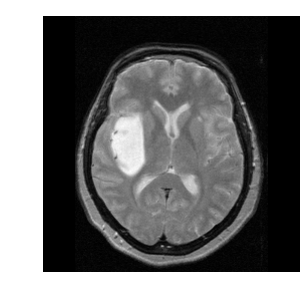

In [7]:
imgSlice_T2 = imgOriginal_T2[:,:,10]

print 'Original image size:', imgSlice_T2.GetSize()

# Reshape to 256x256 pixels (as T1 image)
shrinker = SimpleITK.ShrinkImageFilter()
shrinker.SetShrinkFactors([2,2,1])
imgSlice_T2 = shrinker.Execute(imgSlice_T2)

print 'Reshaped image size:', imgSlice_T2.GetSize()

sitk_show(imgSlice_T2, dpi=100)

In [8]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_T2 = SimpleITK.CurvatureFlow(image1=imgSlice_T2,
                                    timeStep=0.125,
                                    numberOfIterations=5)

##### - With intensity thresholding
(This is only possible on T2 and FLAIR images as the tumour appears bright on these images; contrary to T1 images on which it appears dark)

 - Tumour with Otsu thresholding (automatic thresholding) - does not isolate the tumour correctly

226.866317749


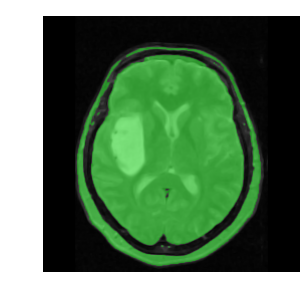

In [9]:
otsu_filter = SimpleITK.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
otsu_filter.SetNumberOfHistogramBins(256)

tumour_otsu = otsu_filter.Execute(imgSmooth_T2)

print otsu_filter.GetThreshold()

imgSmoothOtsu_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_T2), tumour_otsu.GetPixelID())

sitk_show(SimpleITK.LabelOverlay(imgSmoothOtsu_T2, tumour_otsu), dpi=100)

 - Let's try manual thresholding instead - it isolates the tumour along with the cerebrospinal fluid (CSF)

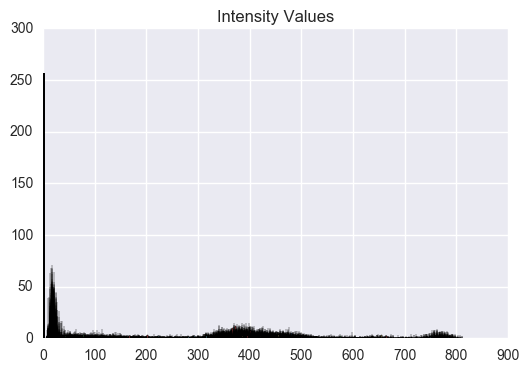

In [11]:
# Get histogram of image intensities

intensity_values_T2 = SimpleITK.GetArrayFromImage(imgSmooth_T2)

plt.hist(intensity_values_T2, bins=256)
plt.title("Intensity Values")
plt.show()

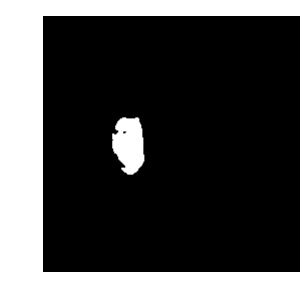

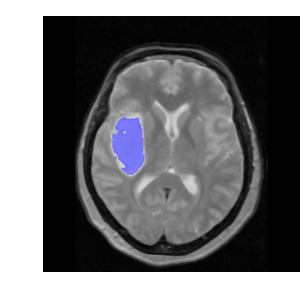

In [97]:
# Tumour segmentation with Binary Thresholding
tumour_thres = SimpleITK.BinaryThreshold(imgSmooth_T2, lowerThreshold=695, upperThreshold=900, 
                                         insideValue=labelTumour, outsideValue=0)

imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_T2), tumour_thres.GetPixelID())

sitk_show(tumour_thres, dpi=100)
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, tumour_thres), dpi=100)

This doesn't isolate the whole tumour perfectly but it seems to be more easily reproducible for other images. We will then be able to extract seeds to compute a confidence connected automatically (without having to define the seeds manually)

In [114]:
# Compute LabelShapeStatisticsImageFilter to get a basic description of the tumour thresholding segmentation
label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_T2.SetBackgroundValue(0)
label_shape_analysis_T2.Execute(tumour_thres)

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x1218f6930> >

In [148]:
# Get main parameters to find seeds

tumour_thres_centroid = label_shape_analysis_T2.GetCentroid(labelTumour)

tumour_thres_principalAxesRotation = label_shape_analysis_T2.GetPrincipalAxes(labelTumour)
cosTheta = tumour_thres_principalAxesRotation[0]

tumour_thres_EllipsoidDiameters = label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)

# Print results
print 'Centroid:', tumour_thres_centroid

print 'Diameter along first principal axis projected on x:', tumour_thres_EllipsoidDiameters[0]*cosTheta
print 'Diameter along second principal axis projected on y:', tumour_thres_EllipsoidDiameters[1]*cosTheta

Centroid: (-31.34336409457893, 16.785521218943032)
Diameter along first principal axis projected on x: 26.1533886984
Diameter along second principal axis projected on y: 49.0573486885


Bounding box start index and size: (69, 102, 32, 57)


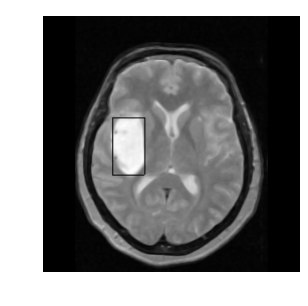

In [118]:
# Get tumour bounding box (alternative method to find seeds)
(x0, y0, l, L) = label_shape_analysis_T2.GetBoundingBox(labelTumour)
print 'Bounding box start index and size:', (x0, y0, l, L)

# Plot bounding box
T2_box = SimpleITK.Image(imgSmoothInt_T2)

T2_box[x0,y0] = 0
    
for x in range(l):
    T2_box[x0+x,y0] = 0
    T2_box[x0+x,y0+L] = 0
    
for y in range(L):
    T2_box[x0,y0+y] = 0
    T2_box[x0+l,y0+y] = 0
    
sitk_show(T2_box, dpi=100)

##### - With confidence connected filter

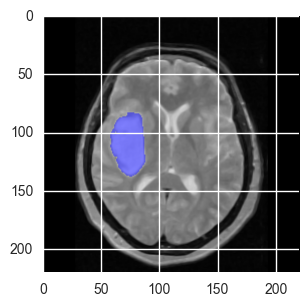

In [119]:
# Segmentation of tumour using confidence connected filter

lstSeeds = [(80, 120), (70, 130)]

imgTumour_T2 = SimpleITK.ConfidenceConnected(image1=imgSmoothInt_T2, 
                                              seedList=lstSeeds,
                                              numberOfIterations=4,
                                              multiplier=4.5,
                                              replaceValue=labelTumour)

sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumour_T2), axis='on', dpi=100)

In [136]:
# Do we get similar sizes and centres with T2 image as for T1 image?

label_shape_analysis_T2 = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_T2.SetBackgroundValue(0)
label_shape_analysis_T2.Execute(imgTumour_T2)

print 'T1 Confidence Connected dimensions'
print 'Centre location:', imgTumour.TransformPhysicalPointToIndex(label_shape_analysis.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis.GetNumberOfPixels(labelTumour)

print '-----'

print 'T2 Confidence Connected dimensions'
print 'Centre location:', imgTumour_T2.TransformPhysicalPointToIndex(label_shape_analysis_T2.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_T2.GetNumberOfPixels(labelTumour)

print '-----'
label_shape_analysis_T2.Execute(tumour_thres)
print 'T2 Thresholding dimensions'
print 'Centre location:', tumour_thres.TransformPhysicalPointToIndex(label_shape_analysis_T2.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_T2.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_T2.GetNumberOfPixels(labelTumour)

T1 Confidence Connected dimensions
Centre location: (84L, 121L)
Ellipsoid diameters: (28.13750164523707, 54.84014536501314)
Number of pixels in tumour: 1641
-----
T2 Confidence Connected dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (29.196359674051465, 54.55822725913134)
Number of pixels in tumour: 1694
-----
T2 Thresholding dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (26.263883270121532, 49.264609429990266)
Number of pixels in tumour: 1376


Please note the thresholding segmentation is quite poor but should only be used to automatically generate seeds for a confidence connected filter.

<a id='Part2'></a>

## 2. In 2D with 4 different sequences (T1, T2, FLAIR and T1 GD)

In [3]:
# Define a function to display the 4 sequences

sequence_names = ['T1', 'T2', 'FLAIR', 'T1 GD']

def sitk_show_4seq(imgs, margin=0.05, dpi=40, axis='off', size=(5,5)):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=size)
        
    for ax, img, seq in zip([ax1,ax2,ax3,ax4], imgs, sequence_names):
        nda = SimpleITK.GetArrayFromImage(img)
        spacing = img.GetSpacing()
        figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
        extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

        plt.set_cmap("gray")
        ax.imshow(nda,extent=extent,interpolation=None)
        ax.set_title(seq)
        ax.axis(axis)
    
    fig.show()

In [5]:
# Load in DICOM images for 1 patient

# Load in the 4 main sequences: T1, T2, FLAIR and post-IV (= T1 GD)
PathDicom_T1 = "../REMBRANDT/900-00-1961/AX_T1/"
PathDicom_T2 = "../REMBRANDT/900-00-1961/AX_T2/"
PathDicom_FLAIR = "../REMBRANDT/900-00-1961/AX_FLAIR/"
PathDicom_T1GD = "../REMBRANDT/900-00-1961/AX_T1_GD/"

# Load in image series
def import_img_series(path):
    reader = SimpleITK.ImageSeriesReader()
    filenamesDICOM = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenamesDICOM)
    return reader.Execute()

img_T1_Original = import_img_series(PathDicom_T1)
img_T2_Original = import_img_series(PathDicom_T2)
img_FLAIR_Original = import_img_series(PathDicom_FLAIR)
img_T1GD_Original = import_img_series(PathDicom_T1GD)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

<a id='Part2a'></a>

### a. Reshape images

In [6]:
# As we can see images have different sizes
for seq, img in zip(sequence_names, img_4seq):
    print seq,':', img.GetSize()

T1 : (256, 256, 20)
T2 : (512, 512, 20)
FLAIR : (256, 256, 20)
T1 GD : (512, 512, 60)


In [7]:
# Resize T2 and T1GD images to 256x256 pixels
shrinker = SimpleITK.ShrinkImageFilter()
shrinker.SetShrinkFactors([2,2,1])
img_T2_Original = shrinker.Execute(img_T2_Original)
img_T1GD_Original = shrinker.Execute(img_T1GD_Original)

img_4seq = [img_T1_Original, img_T2_Original, img_FLAIR_Original, img_T1GD_Original]

for seq, img in zip(sequence_names, img_4seq):
    print seq,':', img.GetSize()

T1 : (256, 256, 20)
T2 : (256, 256, 20)
FLAIR : (256, 256, 20)
T1 GD : (256, 256, 60)


In [8]:
# Images also have slightly different origins and spacings which makes it impossible to superimpose them

print 'Origins:'
for i in img_4seq:
    print i.GetOrigin()
print '---'
print 'Spacings:'
for i in img_4seq:
    print i.GetSpacing()

Origins:
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-104.7949447631836, -93.64041900634766, -70.89044952392578)
(-105.59687042236328, -87.98433685302734, -71.65164947509766)
(-142.36843872070312, -131.2141876220703, -79.95494842529297)
---
Spacings:
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(1.09375, 1.09375, 3.0)


In [9]:
# Redefine images origins and spacings to be able to compose a mix of these 4 images

for i in img_4seq:
    i.SetOrigin((-105.0097885131836, -92.68102264404297, -69.89035034179688))
    i.SetSpacing((0.859375, 0.859375, 7.5))

In [10]:
# Origins and spacing are now the same for all 4 images

print 'Origins:'
for i in img_4seq:
    print i.GetOrigin()
print '---'
print 'Spacings:'
for i in img_4seq:
    print i.GetSpacing()

Origins:
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
(-105.0097885131836, -92.68102264404297, -69.89035034179688)
---
Spacings:
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)
(0.859375, 0.859375, 7.5)


/Users/chloe/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


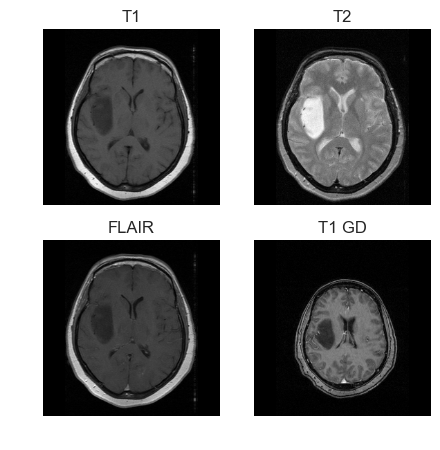

In [11]:
# Define list of images of slice 10 in 4 sequences (2D images)
img_4seq_slice10 = [img_T1_Original[:,:,10], img_T2_Original[:,:,10], 
                    img_FLAIR_Original[:,:,10], img_T1GD_Original[:,:,32]]

sitk_show_4seq(img_4seq_slice10)

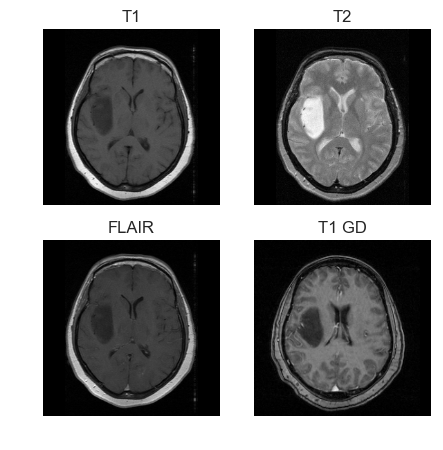

In [12]:
# Crop T1 GD image so it is centered similarly to the other sequences - However size is therefore reduced!
crop_up = SimpleITK.CropImageFilter()
crop_up.SetUpperBoundaryCropSize((20,20))
crop_up.SetLowerBoundaryCropSize((40,40))
img_4seq_slice10[3] = crop_up.Execute(img_4seq_slice10[3])
sitk_show_4seq(img_4seq_slice10)

In [13]:
img_4seq_slice10[3].GetSize()

(196, 196)

In [14]:
scale = SimpleITK.ScaleTransform(2, (256.0/196.0,256.0/196.0))

In [ ]:
resampler = SimpleITK.ResampleImageFilter()
#resampler.SetReferenceImage(img_4seq_slice10[0])
resampler.SetTransform(scale)
img_4seq_slice10[3] = resampler.Execute(img_4seq_slice10[3])

# Display images tiled together in real size
sitk_show(SimpleITK.Tile(img_4seq_slice10,(2,2)))

img_4seq_slice10[3].GetSize()

<a id='Part2b'></a>

### b. Remove noise

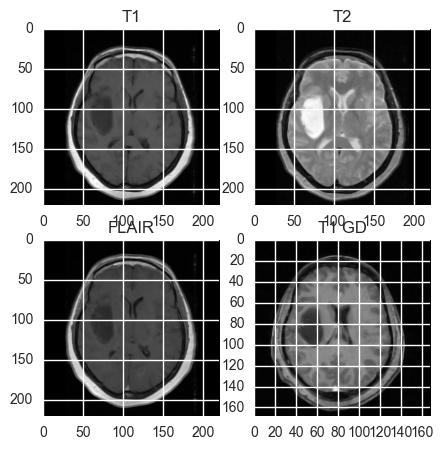

In [73]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_4seq_slice10 = []

for img in img_4seq_slice10:
    imgSmooth_4seq_slice10.append(SimpleITK.CurvatureFlow(image1=img,
                                    timeStep=0.125,
                                    numberOfIterations=5))

sitk_show_4seq(imgSmooth_4seq_slice10, axis='on', size=(5,5))

<a id='Part2c'></a>

### c. Multimodal segmentation - merge T2 and FLAIR images to get a more accurate tumour delimitation

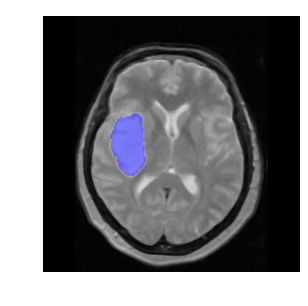

In [70]:
lstSeeds = [(80, 120), (70, 130), (75, 105), (75,140)]

# Merge T2 and FLAIR images
imgComp = SimpleITK.Compose(imgSmooth_4seq_slice10[1], imgSmooth_4seq_slice10[2])

# Compute tumour volume based on newly composed image
imgTumourComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=3,
                                               multiplier=4.7,
                                               replaceValue=labelTumour)
imgSmoothInt_T2 = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgSmooth_4seq_slice10[1]), 
                                           imgTumourComp.GetPixelID())

# Display resulting segmentation on top of composed image
sitk_show(SimpleITK.LabelOverlay(imgSmoothInt_T2, imgTumourComp), dpi=100)

In [74]:
# Get tumour dimensions with this new segmentation

label_shape_analysis_comp = SimpleITK.LabelShapeStatisticsImageFilter()
label_shape_analysis_comp.SetBackgroundValue(0)
label_shape_analysis_comp.Execute(imgTumourComp)

print 'T2 and FLAIR composed image Confidence Connected dimensions'
print 'Centre location:', imgTumourComp.TransformPhysicalPointToIndex(label_shape_analysis_comp.GetCentroid(labelTumour))
print 'Ellipsoid diameters:', label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour)
print 'Number of pixels in tumour:', label_shape_analysis_comp.GetNumberOfPixels(labelTumour)

T2 and FLAIR composed image Confidence Connected dimensions
Centre location: (85L, 128L)
Ellipsoid diameters: (28.811608007863505, 53.132769385781444)
Number of pixels in tumour: 1628


In [92]:
# Define fonction to convert tumour diameters to originally encoded labels from 1 to 18
def size_label(x):
    j = round(x,1)
    if j<5:
        return 1
    elif j<=7.5:
        return 2
    elif j<=12.5:
        return 3
    elif j<=17.5:
        return 4
    elif j<=22.5:
        return 5
    elif j<=27.5:
        return 6
    elif j<=32.5:
        return 7
    elif j<=37.5:
        return 8
    elif j<=42.5:
        return 9
    elif j<=47.5:
        return 10
    elif j<=52.5:
        return 11
    elif j<=57.5:
        return 12
    elif j<=62.5:
        return 13
    elif j<=67.5:
        return 14
    elif j<=72.5:
        return 15
    elif j<=77.5:
        return 16
    elif j<=80:
        return 17
    else:
        return 18

# Define function to return largest encoded diametre first
def convert_size_to_label((x,y)):
    a=0
    b=0
    # Largest returned diameter first 
    if x>y:
        a=x
        b=y
    else:
        a=y
        b=x
    # Assign labels to each diameter
    return (size_label(a),size_label(b))

In [86]:
# Define fonction to convert tumour centre location to originally encoded label: 3 if left, 1 if right, 2 if centre
# This refers to the side of the brain so it will appear on the opposite side on the image (mirror effect)
# /!\ HOW TO CHECK IF BILATERAL??

def convert_centre_location_to_side_label((x,y)):
    if int(x)>128:
        return 3
    elif int(x)<128:
        return 1
    else:
        return 2

In [94]:
# Compare with manually calculated dimanesions (stored in tumours dataframe)

print 'Automatically computed features'
print 'X dimension:', convert_size_to_label(label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour))[0]
print 'Y dimension:', convert_size_to_label(label_shape_analysis_comp.GetEquivalentEllipsoidDiameter(labelTumour))[1]
print 'Side of tumour epicentre:', convert_centre_location_to_side_label(imgTumourComp.TransformPhysicalPointToIndex(label_shape_analysis_comp.GetCentroid(labelTumour)))

print '-------'

print 'Manually extracted features (from tumours dataframe)'
print 'X dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_x'].values[0]
print 'Y dimension:', tumours.loc[tumours['Sample']=='900_00_1961', 'Lesion_Size_y'].values[0]
print 'Side of tumour epicentre:', tumours.loc[tumours['Sample']=='900_00_1961', 'Side_of_Tumor_Epicenter'].values[0]

Automatically computed features
X dimension: 12
Y dimension: 7
Side of tumour epicentre: 1
-------
Manually extracted features (from tumours dataframe)
X dimension: 11
Y dimension: 7
Side of tumour epicentre: 1


<a id='Part3'></a>

## 3. In 3D

In [85]:
def sitk_show_slices(imgs, margin=0.05, dpi=40, axis='off', size=(10,10), first_slice=8, last_slice=14):
    fig, im = plt.subplots(4, last_slice - first_slice +1, figsize=size)
        
    for ax, img, seq in zip([im[0],im[1],im[2],im[3]], imgs, sequence_names):
        for i in range(first_slice, last_slice+1):
            nda = SimpleITK.GetArrayFromImage(img[:,:,i])
            spacing = img[:,:,i].GetSpacing()
            figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
            extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)

            plt.set_cmap("gray")
            ax[i-first_slice].imshow(nda,extent=extent,interpolation=None)
            ax[i-first_slice].set_title(seq+', slice'+str(i))
            ax[i-first_slice].axis(axis)
    
    fig.show()

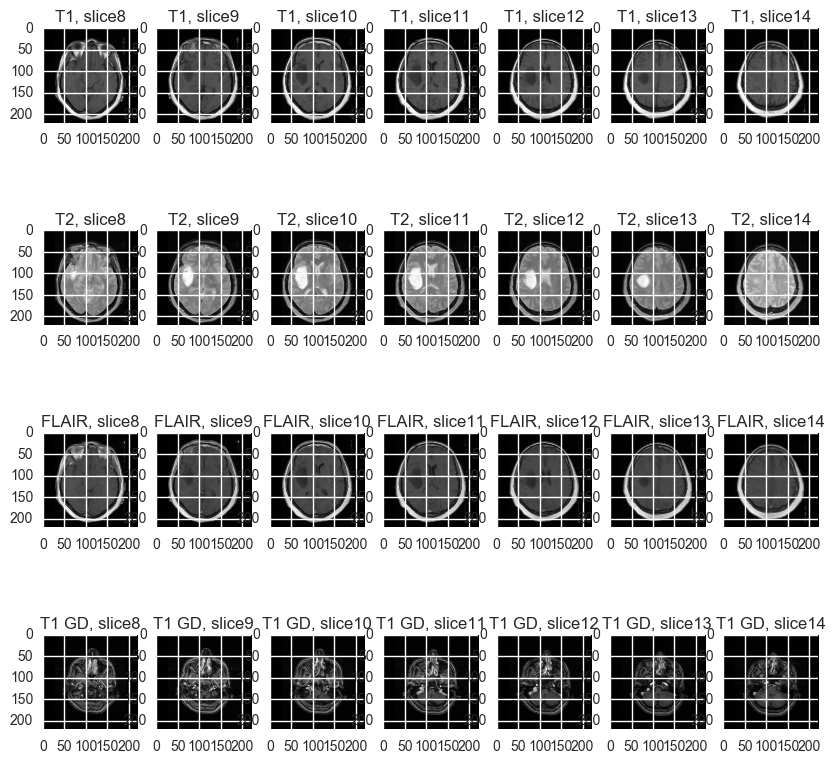

In [87]:
# Apply a curvature-flow filter to smoothen the image (get rid of image noise)

imgSmooth_4seq = []

for img in img_4seq:
    imgSmooth_4seq.append(SimpleITK.CurvatureFlow(image1=img,
                                    timeStep=0.125,
                                    numberOfIterations=5))

sitk_show_slices(imgSmooth_4seq, axis='on')

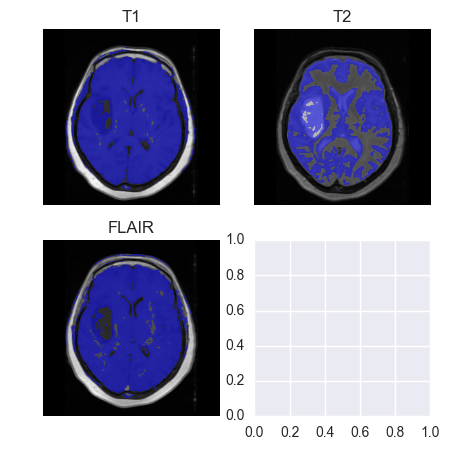

In [66]:
# Segmentation of tumour in each sequence

lstSeeds = [(80,120,10), (70,130,10), (75,105,10), (75,140,10), (75,110,9), (75,110,11), (75,110,12), (75,120,13)]

imgTumour_perseq = []
imgSmoothInt_4seq = []

for img in imgSmooth_4seq[:-1]:
    tum = SimpleITK.ConfidenceConnected(image1=img, seedList=lstSeeds, numberOfIterations=3,
                                        multiplier=0.5,replaceValue=labelTumour)
    imgTumour_perseq.append(tum)
    imgSmoothInt_4seq.append(SimpleITK.Cast(SimpleITK.RescaleIntensity(img), tum.GetPixelID()))
    
imgTumour_perseq_slice10 = [imgTumour_perseq[0][:,:,10], imgTumour_perseq[1][:,:,10], 
                            imgTumour_perseq[2][:,:,10]] #, imgTumour_perseq[3][:,:,32]] 

imgSmoothInt_4seq_slice10 = [imgSmoothInt_4seq[0][:,:,10], imgSmoothInt_4seq[1][:,:,10], 
                            imgSmoothInt_4seq[2][:,:,10]] #, imgSmoothInt_4seq[3][:,:,32]]


sitk_show_4seq([SimpleITK.LabelOverlay(i,j) for i,j in zip(imgSmoothInt_4seq_slice10, imgTumour_perseq_slice10)])